# Demonstration of CG building of linear polymer chains

## Utility functions

In [1]:
from enum import Enum

import numpy as np
from scipy.spatial.transform import Rotation, RigidTransform

from rdkit.Chem import Mol, MolFromSmiles, AddHs
from rdkit.Chem.rdMolTransforms import TransformConformer
from rdkit.Chem.AllChem import EmbedMolecule

from mupt.geometry.transforms.rigid import rigid_vector_coalignment

In [2]:
class CoordAxis(Enum):
    X = 0
    Y = 1
    Z = 2
    
POS_1_IDX : int = 1
POS_2_IDX : int = 2

def mol_aligned_to_axis(smiles : str, axis : CoordAxis=CoordAxis.X) -> tuple[Mol, int, int]:
    '''
    Initialize a Mol with a pair of marked positions pinned to the x-axis, equidistant from the origin
    Returns the mol (with associated conformer), the bound conformer ID, and the semi-axis length
    '''
    mol = MolFromSmiles(smiles, sanitize=True)
    mol = AddHs(mol)
    conf_id : int = EmbedMolecule(mol) # positions are determined here
    conf = mol.GetConformer(conf_id)

    span_atom_pos : dict[str, np.ndarray] = {}
    for atom in mol.GetAtoms():
        if (map_num := atom.GetAtomMapNum()):
            span_atom_pos[map_num] = conf.GetAtomPosition(atom.GetIdx())
    pos1 = np.array(span_atom_pos[POS_1_IDX])
    pos2 = np.array(span_atom_pos[POS_2_IDX])
    
    semimajor = np.linalg.norm(pos2 - pos1) / 2.0
    axis_vec = np.zeros(3, dtype=float)
    axis_vec[axis.value] = semimajor
    
    axis_alignment = rigid_vector_coalignment(
        vector1_start=pos1,
        vector1_end=pos2,
        vector2_start=np.zeros(3, dtype=float),
        vector2_end=axis_vec,
        t1=1/2,
        t2=0.0,
    )
    TransformConformer(conf, trans=axis_alignment.as_matrix())

    return mol, conf_id, semimajor

## Compile lexicon of unit repeat units (with fitted Ellipsoidal shapes)

In [3]:
AXIS : CoordAxis = CoordAxis.X
ORIGIN : np.ndarray = np.array([0.0, 0.0, 0.0], dtype=float)
SEMIMINOR_FRACT : float = 0.5 # how long the pair of minor axes should be as a fraction of the major axis length

head


[17:59:45] UFFTYPER: Unrecognized atom type: *_ (16)


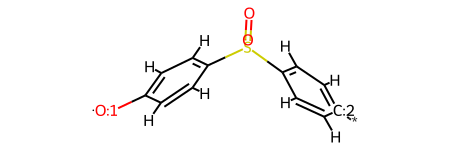

mid


/home/timber/miniconda3/envs/mupt-dev/lib/python3.13/site-packages/networkx/algorithms/graph_hashing.py:211: UserWarning: The hashes produced for graphs without node or edge attributeschanged in v3.5 due to a bugfix (see documentation).
  node_labels = _init_node_labels(G, edge_attr, node_attr)
[17:59:45] UFFTYPER: Unrecognized atom type: *_ (0)
[17:59:45] UFFTYPER: Unrecognized atom type: *_ (17)


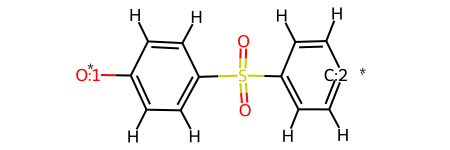

tail


[17:59:45] UFFTYPER: Unrecognized atom type: *_ (0)


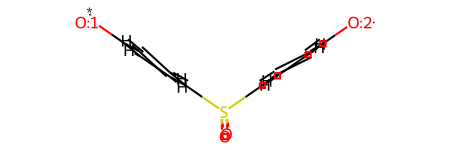

In [4]:
from mupt.mupr.primitives import Primitive
from mupt.geometry.shapes import PointCloud, Ellipsoid
from mupt.interfaces.rdkit import primitive_from_rdkit


rep_unit_smiles : dict[str, str] = {
    'head' : f'[O:{POS_1_IDX}]c1ccc(cc1)S(=O)(=O)c1cc[c:{POS_2_IDX}](cc1)-*',
    'mid'  : f'*-[O:{POS_1_IDX}]c1ccc(cc1)S(=O)(=O)c1cc[c:{POS_2_IDX}](cc1)-*',
    'tail' : f'*-[O:{POS_1_IDX}]c1ccc(cc1)S(=O)(=O)c1ccc(cc1)[O:{POS_2_IDX}]',
}

lexicon : dict[str, Primitive] = {}
for unit_name, smiles in rep_unit_smiles.items():
    mol, conf_id, semimajor = mol_aligned_to_axis(smiles, axis=AXIS)
    semiminor = SEMIMINOR_FRACT * semimajor
    print(unit_name)
    display(mol)

    prim = primitive_from_rdkit(mol, conformer_id=conf_id, label=unit_name)
    radii = np.full(3, semiminor)
    radii[AXIS.value] = semimajor
    prim.shape = Ellipsoid(radii)

    lexicon[unit_name] = prim

## Construct Primitive representing homopolymer chain of given length
All units in reference position (i.e. level and centered at origin) for the moment

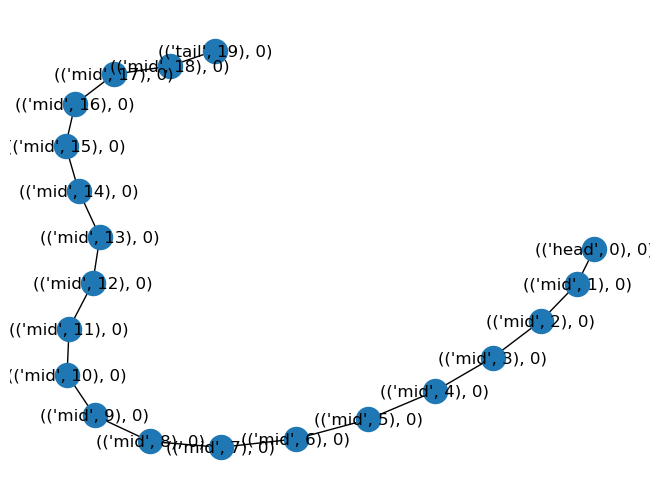

In [5]:
import networkx as nx
from mupt.mupr.topology import TopologicalStructure


N_REPEAT_UNITS : int = 20

molprim = Primitive(label='polymer_chain')
unit_names : list[str] = ['head'] + ['mid']*(N_REPEAT_UNITS - 2) + ['tail']
for i, unit_name in enumerate(unit_names)   :
    rep_unit_prim = lexicon[unit_name].copy()
    rep_unit_prim.label = (unit_name, i) # DEV: temporary, while uniquified child registration is implemented
    molprim.attach_child(rep_unit_prim)

molprim.topology = nx.path_graph(molprim.children_by_handle.keys(), create_using=TopologicalStructure)
nx.draw(molprim.topology, with_labels=True)

## Generate and apply centers + orientations for each repeat unit
Produced here from freely-jointed chain (stand-in for DPDP, self-avoiding RW, whatever)  
Encapsulate both center and orient as a single rigid transformation

In [6]:
from typing import Generator

from mupt.geometry.random_walk import random_walk_jointed_chain


def step_size() -> Generator[int, None, None]:
    '''Produce the appropriate step lengths for each segment of the random walk'''
    for child in molprim.children:
        yield 2*child.shape.radii[AXIS.value]

points = random_walk_jointed_chain(
    n_steps_max=N_REPEAT_UNITS,
    step_size=step_size(), # length of ellipsoid plus 2 halves of a bond on either end
    clip_angle=np.pi*1/4, # maximum allowable angle between consecutive vectors
    starting_point=ORIGIN,
)

In [7]:
transformations : list[RigidTransform] = []
for (step_start, step_end, res_prim) in zip(points[:-1], points[1:], molprim.children):
    placement_transform = rigid_vector_coalignment(
        ORIGIN,
        res_prim.shape.principal_axes[AXIS.value],
        step_start,
        step_end,
        t1=0.0,
        t2=1/2,
    )
    res_prim.rigidly_transform(placement_transform)
    transformations.append(placement_transform)

## TODO: ballistically-align Connectors on neighboring Primitives

## Visualize placement of subprimitives
Ellipsoids for residues and points for individual atoms

In [8]:
# optional; can apply a rigid transformation to the ENTIRE molecule at once - 
random_rot = RigidTransform.from_rotation(Rotation.random())
molprim.rigidly_transform(random_rot)

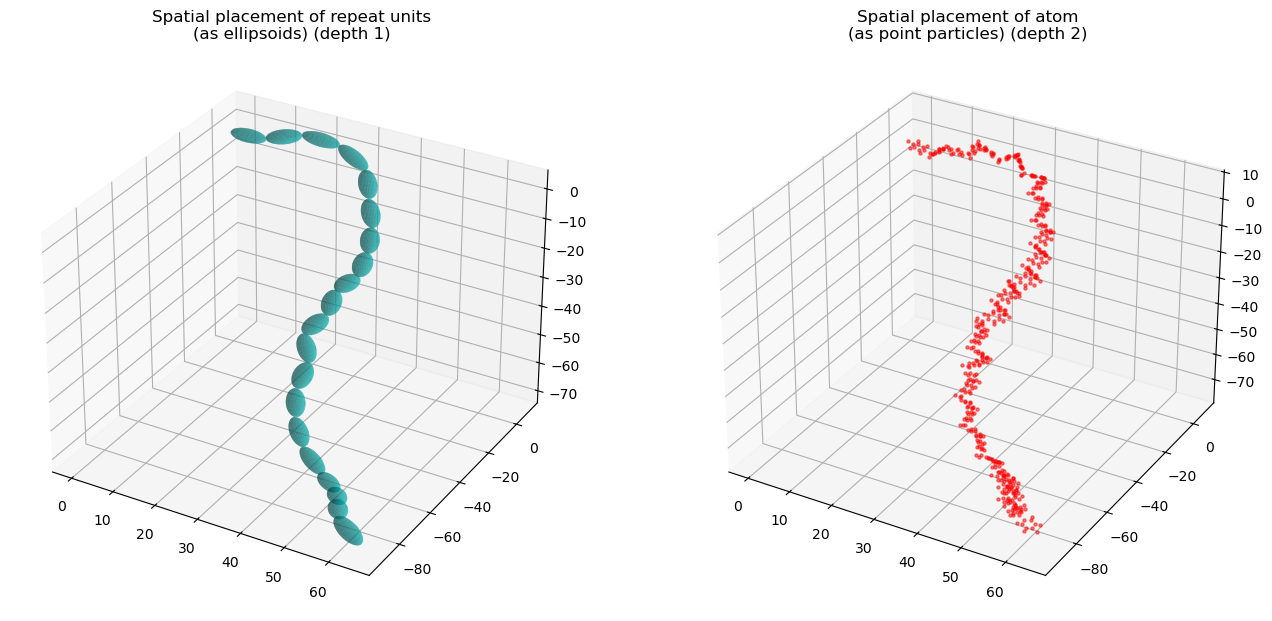

In [9]:
from anytree.iterators import LevelOrderGroupIter

import matplotlib.pyplot as plt
# %matplotlib ipympl


scale : float=16
aspect : float = 1/2
plt.close()
fig = plt.figure(figsize=(scale, scale*aspect))
fig.canvas.header_visible = False

levels : dict[int, tuple[Primitive]] = {i : grp for i, grp in enumerate(LevelOrderGroupIter(molprim))}

ellip_depth : int = 1
ax_ellip = fig.add_subplot(1, 2, ellip_depth, projection='3d')
ax_ellip.autoscale(enable=True)
ax_ellip.set_title(f'Spatial placement of repeat units\n(as ellipsoids) (depth {ellip_depth})')
for res_prim in levels[ellip_depth]:
    _ = ax_ellip.plot_surface(*res_prim.shape.surface_mesh(20, 20).T, color='c', alpha=0.5)

atom_depth : int = 2
ax_atomic = fig.add_subplot(1, 2, atom_depth, projection='3d')
ax_atomic.autoscale(enable=True)
ax_atomic.set_title(f'Spatial placement of atom\n(as point particles) (depth {atom_depth})')
for res_prim in levels[atom_depth]:
    _ = ax_atomic.scatter(*res_prim.shape.positions.T, color='r', marker='.', alpha=0.5)

## [WIP] Flatten Primitive hierarchy and export as all-atom system

In [10]:
from rdkit.Chem import MolToMolFile
from mupt.interfaces.rdkit import primitive_to_rdkit


chain : Mol = primitive_to_rdkit(molprim) # NOTE: this doesn't work ATM; proofing pseudo-code here to show what this ought to look like
MolToMolFile(chain, 'ellipsoidal_PPS_chain.mol')

NotImplementedError: 